# This section imports all the necessary libraries for data handling, modeling, evaluation, and visualization. 
We use LightGBM for gradient boosting, Keras for LSTM modeling, and matplotlib for plotting results.


In [29]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten

# This function loads stock data from a CSV file and prepares it for model training. 
It builds sequences of past prices for LSTM and engineered features like lags, moving averages, and date features for LightGBM. The output is split into features and labels.

In [30]:
def load_and_prepare_data(file_path, lookback=60, model_type="LSTM"):
    # Load the CSV and convert Date column to datetime
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)  # Ensure data is in time order
    
    if model_type == "LIGHTGBM":
        # ➕ Create additional features for LightGBM model
        
        # Moving averages for trend
        df['MA_5'] = df['Close'].rolling(window=5).mean()
        df['MA_10'] = df['Close'].rolling(window=10).mean()
        
        # Momentum: Price change over last 5 days
        df['Momentum'] = df['Close'] - df['Close'].shift(5)
        
        # Volatility: Rolling standard deviation
        df['Volatility'] = df['Close'].rolling(window=5).std()
        
        # Date-based features
        df['DayOfWeek'] = df['Date'].dt.dayofweek
        df['Month'] = df['Date'].dt.month

        # Lag features
        for lag in range(1, lookback + 1):
            df[f'Lag_{lag}'] = df['Close'].shift(lag)

        df.dropna(inplace=True)  # Drop rows with NaNs caused by lag features

        # Define feature columns
        feature_cols = [f'Lag_{i}' for i in range(1, lookback + 1)] + [
            'MA_5', 'MA_10', 'Momentum', 'Volatility', 'DayOfWeek', 'Month'
        ]

        # Feature matrix and target
        X = df[feature_cols].values
        y = df['Close'].values

        return X, y, None, df

    else:  # Preprocessing for LSTM
        data = df[['Close']].values

        # Scale prices between 0 and 1 for LSTM
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data)

        X, y = [], []

        # Create sequences of 60 days to predict the next day
        for i in range(lookback, len(scaled_data)):
            X.append(scaled_data[i - lookback:i, 0])
            y.append(scaled_data[i, 0])

        # Reshape into format suitable for LSTM input
        X = np.array(X)
        y = np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        return X, y, scaler, df

# This function builds and compiles a simple LSTM model with one LSTM layer followed by a Dense output layer. 
The model uses mean squared error loss and Adam optimizer, suitable for time series regression tasks.

In [31]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=input_shape))  # One LSTM layer
    model.add(Dense(1))  # Final output layer
    model.compile(optimizer='adam', loss='mean_squared_error')  # MSE loss for regression
    return model

# This function performs hyperparameter tuning for a LightGBM model using a grid search approach. 
It tries different combinations of parameters and selects the one that achieves the lowest RMSE on the validation set.

In [32]:
def train_lightgbm_model(X_train, y_train, X_test, y_test):
    best_model = None
    best_rmse = float('inf')
    best_params = {}

    # Define parameter grid for tuning
    param_grid = {
        'num_leaves': [15, 31, 50],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_child_samples': [10, 20],
        'lambda_l2': [0.0, 0.1]
    }

    # Grid search over all parameter combinations
    for num_leaves in param_grid['num_leaves']:
        for lr in param_grid['learning_rate']:
            for min_child in param_grid['min_child_samples']:
                for l2 in param_grid['lambda_l2']:
                    params = {
                        'objective': 'regression',
                        'metric': 'l2',
                        'learning_rate': lr,
                        'num_leaves': num_leaves,
                        'min_child_samples': min_child,
                        'lambda_l2': l2,
                        'verbose': -1,
                        'seed': 42
                    }

                    # Create LightGBM datasets
                    train_data = lgb.Dataset(X_train, label=y_train)
                    valid_data = lgb.Dataset(X_test, label=y_test)

                    # Train model with early stopping
                    booster = lgb.train(
                        params=params,
                        train_set=train_data,
                        num_boost_round=100,
                        valid_sets=[valid_data],
                        valid_names=['valid'],
                        callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
                    )

                    # Evaluate model
                    preds = booster.predict(X_test, num_iteration=booster.best_iteration)
                    rmse = np.sqrt(mean_squared_error(y_test, preds))

                    # Update best model if current is better
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_model = booster
                        best_params = params

    print("Best LightGBM params:", best_params)
    print("Best RMSE:", round(best_rmse, 4))
    return best_model

# This function handles the entire workflow of training and evaluating a model on stock price data. 
It loads the data, trains either an LSTM or LightGBM model, evaluates performance using standard metrics, plots results, and saves predictions to a CSV file for further use.

In [33]:
def train_and_evaluate(file_path, stock_name, model_type="LSTM"):
    print(f"\nTraining model for {stock_name} using {model_type}")
    lookback = 60  # Sequence length for LSTM or lag size for LightGBM
    X, y, scaler, df = load_and_prepare_data(file_path, lookback, model_type=model_type)

    # Train-test split (80/20)
    split = int(0.8 * len(X))
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]

    history = None  # For tracking LSTM training history

    if model_type == "LSTM":
        # Build and train LSTM model
        model = build_lstm_model((lookback, 1))
        history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                            validation_data=(X_test, y_test), verbose=1)

        # Predict on train and test
        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)

        # Rescale to actual price
        train_predictions = scaler.inverse_transform(train_predictions)
        train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
        test_predictions = scaler.inverse_transform(test_predictions)
        test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    elif model_type == "LIGHTGBM":
        # Flatten input (already 2D but reshaped here for clarity)
        X_train_flat = X_train.reshape((X_train.shape[0], X_train.shape[1]))
        X_test_flat = X_test.reshape((X_test.shape[0], X_test.shape[1]))

        # Train and predict
        booster = train_lightgbm_model(X_train_flat, y_train, X_test_flat, y_test)
        train_predictions = booster.predict(X_train_flat, num_iteration=booster.best_iteration).reshape(-1, 1)
        test_predictions = booster.predict(X_test_flat, num_iteration=booster.best_iteration).reshape(-1, 1)

        train_actual = y_train.reshape(-1, 1)
        test_actual = y_test.reshape(-1, 1)

    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Evaluation Metrics

    train_mse = mean_squared_error(train_actual, train_predictions)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(train_actual, train_predictions)
    train_r2 = r2_score(train_actual, train_predictions)

    test_mse = mean_squared_error(test_actual, test_predictions)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(test_actual, test_predictions)
    test_r2 = r2_score(test_actual, test_predictions)

    # Metrics Table Plot
    fig, ax = plt.subplots(figsize=(7.5, 3))
    ax.axis('tight')
    ax.axis('off')

    comparison_table = [
        ["Metric", "Train", "Test"],
        ["MSE", f"{train_mse:.4f}", f"{test_mse:.4f}"],
        ["RMSE", f"{train_rmse:.4f}", f"{test_rmse:.4f}"],
        ["MAE", f"{train_mae:.4f}", f"{test_mae:.4f}"],
        ["R² Score", f"{train_r2:.4f}", f"{test_r2:.4f}"]
    ]

    table = ax.table(cellText=comparison_table, cellLoc='center', loc='center')
    table.scale(1.2, 2)
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    plt.title(f"{stock_name} - {model_type} Metrics", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Plot Loss Curve (LSTM only)
    if history:
        plt.figure(figsize=(10, 4))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f"{stock_name} {model_type} Training Loss over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (MSE)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Actual vs Predicted Price Plot
    plt.figure(figsize=(10, 4))
    plt.plot(test_actual, label='Actual Price')
    plt.plot(test_predictions, label='Predicted Price')
    plt.title(f"{stock_name} {model_type} - Predicted vs Actual Closing Price")
    plt.xlabel("Days")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save Predictions to CSV
    prediction_dates = df['Date'].iloc[len(df) - len(y_test):].reset_index(drop=True)
    prediction_df = pd.DataFrame({
        'Date': prediction_dates,
        'Actual Price': test_actual.flatten(),
        'Predicted Price': test_predictions.flatten()
    })
    prediction_df['Year'] = prediction_df['Date'].dt.year
    output_path = f"data/output/predictions_{stock_name}_{model_type}.csv"
    prediction_df.to_csv(output_path, index=False)

    return test_predictions, test_actual

# Finally, we train and evaluate both models (LSTM and LightGBM) on the SPY stock data. 
This lets us compare their performance on the same dataset.


Training model for SPY using LSTM
Epoch 1/20


/opt/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0099 - val_loss: 5.7910e-04
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0933e-04 - val_loss: 7.7225e-04
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0085e-04 - val_loss: 7.5967e-04
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.9593e-05 - val_loss: 6.5553e-04
Epoch 5/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.6129e-05 - val_loss: 6.1733e-04
Epoch 6/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7490e-05 - val_loss: 4.5408e-04
Epoch 7/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9522e-05 - val_loss: 3.5141e-04
Epoch 8/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9519e-05 - val_loss: 4.0189e-04
Epoch 9/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7440e-05 - val_loss: 2.9705e-04
Epoch 10/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.7351e-05 - val_loss: 2.7426e-04
Epoch 11/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.9839e-05 - 

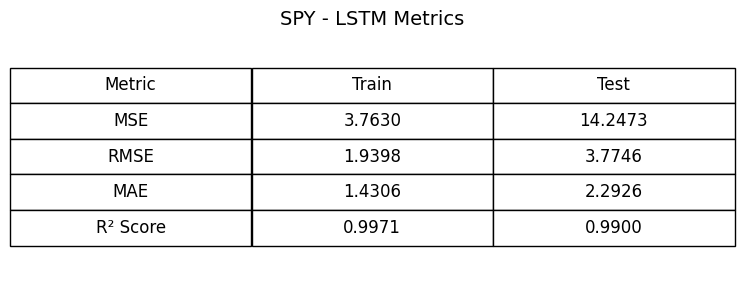

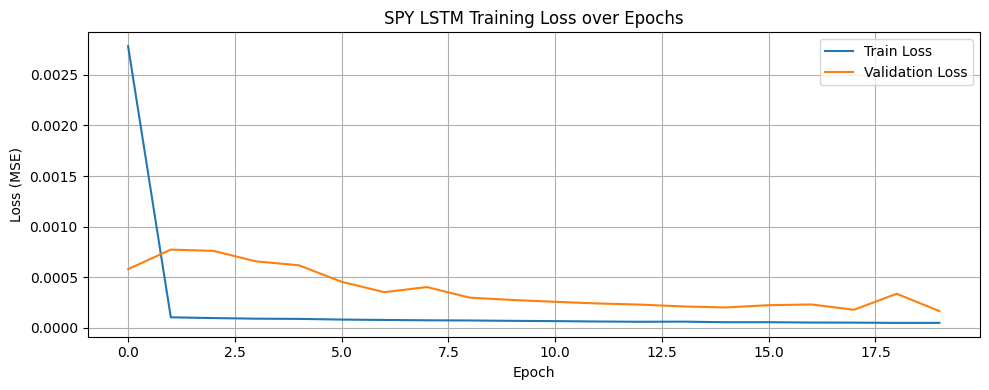

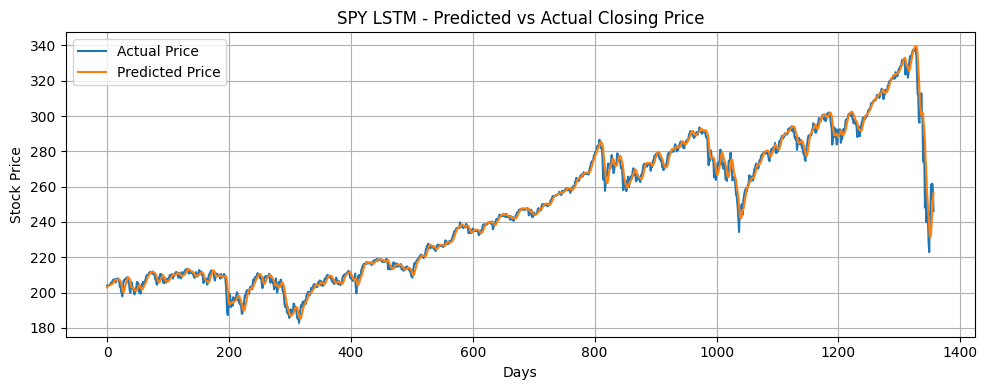


Training model for SPY using LIGHTGBM
Best LightGBM params: {'objective': 'regression', 'metric': 'l2', 'learning_rate': 0.1, 'num_leaves': 50, 'min_child_samples': 10, 'lambda_l2': 0.1, 'verbose': -1, 'seed': 42}
Best RMSE: 59.524


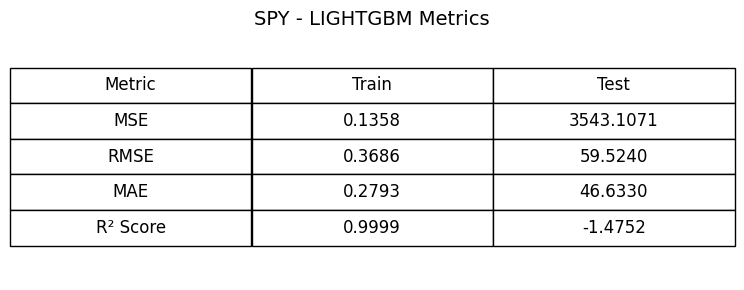

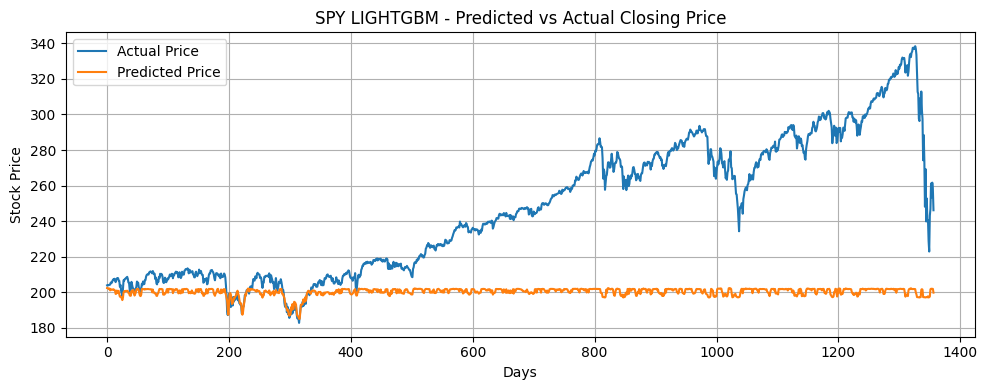

In [34]:
# Train both models for SPY
spy_lstm_pred, spy_lstm_actual = train_and_evaluate("data/stocks/SPY.csv", "SPY", model_type="LSTM")
spy_lgbm_pred, spy_lgbm_actual = train_and_evaluate("data/stocks/SPY.csv", "SPY", model_type="LIGHTGBM")